# SETUP

In [1]:
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Mounted at /content/gdrive


In [2]:
import os
os.chdir("/content/gdrive/My Drive/jax_learn_to_learn")

In [3]:
!pip3 install git+https://github.com/deepmind/dm-haiku

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-8475cqnn
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-8475cqnn
  Created wheel for dm-haiku: filename=dm_haiku-0.0.6.dev0-py3-none-any.whl size=537377 sha256=40b2946c496835ba0f86e27ce9e13d9f5ce5f94f021b33465b231d9db5edac34
  Stored in directory: /tmp/pip-ephem-wheel-cache-cf32np_l/wheels/06/28/69/ebaac5b2435641427299f29d88d005fb4e2627f4a108f0bdbc
Successfully built dm-haiku


In [4]:
import haiku as hk

import jax
import jax.numpy as jnp
from jax import grad, jit, value_and_grad
import jax.experimental.optimizers as optimizers
import jax.random as random
import jax.lax as lax
import jax.nn as nn

import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [5]:
key = random.PRNGKey(16892)

# LSTM Optimizer

In [7]:
hidden_sz = 20

In [8]:
def _lstm(x, prev_state_1, prev_state_2):
  fc1 = hk.Linear(hidden_sz, name = 'fc1')
  lstm1 = hk.LSTM(hidden_sz, name = 'lstm1')
  lstm2 = hk.LSTM(hidden_sz, name = 'lstm2')
  fc2 = hk.Linear(1, name = 'fc2')

  x = nn.relu(fc1(x))
  
  h_1, state_1 = lstm1(x, prev_state_1)
  h_2, state_2 = lstm2(h_1, prev_state_2)

  return 0.1 * fc2(h_2), state_1, state_2

lstm = hk.without_apply_rng(hk.transform(_lstm))

def lstm_forward(lstm_params, x, prev_state_1, prev_state_2):
  return lstm.apply(lstm_params, x, prev_state_1, prev_state_2)

In [9]:
def init_lstm_params(lstm_params):
  lstm_params = hk.data_structures.to_mutable_dict(lstm_params)
  for layer in lstm_params:
    w = torch.rand(lstm_params[layer]['w'].shape)
    torch.nn.init.xavier_uniform_(w)
    w = w.numpy()
    lstm_params[layer]['w'] = jnp.array(w)
  lstm_params = hk.data_structures.to_immutable_dict(lstm_params)
  return lstm_params

# Gradient Preprocessing

In [10]:
def preproc_raw(g):
  return g

def preproc_log(g):
  return jnp.sign(g)*jnp.minimum(jnp.log1p(jnp.abs(g)) / 10.0, 1)

# MLP for MNIST

In [11]:
def _mlp(x):
  fc1 = hk.Linear(20, name = 'fc1')
  fc2 = hk.Linear(10, name = 'fc2')

  return fc2(nn.sigmoid(fc1(x)))

mlp = hk.without_apply_rng(hk.transform(_mlp))

def mlp_forward(mlp_params, x, y):
  y_ = mlp.apply(mlp_params, x)
  log_y_ = nn.log_softmax(y_)

  loss = 0.0
  for i in range(x.shape[0]):
    loss -= log_y_[i][y[i]]
  loss /= x.shape[0]

  return loss, y_

vag_mlp_forward = value_and_grad(mlp_forward, has_aux=True)

In [12]:
#https://roberttlange.github.io/posts/2020/03/blog-post-10/
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
trainset = torchvision.datasets.MNIST(root = './data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root = './data', train=False, download=True, transform=transform)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [13]:
train_sz = 400
outer_steps = 5
inner_steps = 20
val_sz = 50
val_steps = (outer_steps * inner_steps) * 2
test_sz = 100
test_steps = (outer_steps * inner_steps) * 2

batch_sz = 16
mnist_sz = test_steps * batch_sz

TEST_STEPS = test_steps
INNER_STEPS = inner_steps

In [14]:
trainset_dict = {}
stop = np.zeros(10)

for data, label in trainset:
  if stop[label] == 1:
    continue

  if label not in trainset_dict:
    trainset_dict[label] = ((np.array(data)).reshape(-1))[None,:]
  else:
    trainset_dict[label] = np.concatenate((trainset_dict[label],((np.array(data)).reshape(-1))[None,:]),0)
    if trainset_dict[label].shape[0] == 3 * mnist_sz / 10:
      stop[label] = 1

  if np.sum(stop) == 10:
    break

In [15]:
train_mnist = None
train_labels = []
val_mnist = None
val_labels = []
test_mnist = None
test_labels = []

for label in range(10):
  if label == 0:
    train_mnist = trainset_dict[label][:mnist_sz//10,:]
    val_mnist = trainset_dict[label][mnist_sz//10:2*mnist_sz//10,:]
    test_mnist = trainset_dict[label][2*mnist_sz//10:3*mnist_sz//10,:]

  else:
    train_mnist = np.concatenate((train_mnist,trainset_dict[label][:mnist_sz//10,:]),0)
    val_mnist = np.concatenate((val_mnist,trainset_dict[label][mnist_sz//10:2*mnist_sz//10,:]),0)
    test_mnist = np.concatenate((test_mnist,trainset_dict[label][2*mnist_sz//10:3*mnist_sz//10,:]),0)

  train_labels = train_labels + [label] * (mnist_sz//10)
  val_labels = val_labels + [label] * (mnist_sz//10)
  test_labels = test_labels + [label] * (mnist_sz//10)

In [16]:
train_mnist = jnp.array(train_mnist)
train_labels = jnp.array(train_labels)
val_mnist = jnp.array(val_mnist)
val_labels = jnp.array(val_labels)
test_mnist = jnp.array(test_mnist)
test_labels = jnp.array(test_labels)

In [17]:
train_mlp_params = []
train_orders = []
val_mlp_params = []
val_orders = []
test_mlp_params = []
test_orders = []

for i in range(train_sz):
  key, subkey1, subkey2 = random.split(key, 3)
  train_mlp_params.append(mlp.init(subkey1, jnp.ones((batch_sz,784))))
  train_orders.append(random.shuffle(subkey2,jnp.arange(0,len(train_labels))))

for i in range(val_sz):
  key, subkey1, subkey2 = random.split(key, 3)
  val_mlp_params.append(mlp.init(subkey1, jnp.ones((batch_sz,784))))
  val_orders.append(random.shuffle(subkey2,jnp.arange(0,len(val_labels))))

for i in range(test_sz):
  key, subkey1, subkey2 = random.split(key, 3)
  test_mlp_params.append(mlp.init(subkey1, jnp.ones((batch_sz,784))))
  test_orders.append(random.shuffle(subkey2,jnp.arange(0,len(test_labels))))

/usr/local/lib/python3.7/dist-packages/jax/_src/random.py:321: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation
  warnings.warn(msg, FutureWarning)


# MLP ADAM

In [18]:
@jit
def mlp_adam_step(step, opt_state, mnist_batch, labels_batch, lr):
  (loss_mlp, _), grads_mlp = vag_mlp_forward(get_params(opt_state), mnist_batch, labels_batch)
  _, opt_update, _ = optimizers.adam(lr)
  opt_state = opt_update(step, grads_mlp, opt_state)
  return opt_state, loss_mlp
@jit
def mlp_adam_f(carry, i):
  mnist_batch = lax.dynamic_slice(carry[1], [i*batch_sz, 0], [batch_sz, carry[1].shape[1]])
  labels_batch = lax.dynamic_slice(carry[2], [i*batch_sz], [batch_sz])
  opt_state, loss_mlp = mlp_adam_step(i, carry[0], mnist_batch, labels_batch, carry[3])
  carry = [opt_state, carry[1], carry[2], carry[3]]
  return carry, loss_mlp

@jit
def mlp_adam_update_scan(opt_state, mnist_, labels_, lr):
  idx = jnp.arange(0, TEST_STEPS)
  init = [opt_state, mnist_, labels_, lr]
  [new_opt_state, _, _, _], losses_mlp = lax.scan(mlp_adam_f, init, idx)
  return new_opt_state, losses_mlp

In [19]:
# ADAM
lrs = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

mlp_adam_losses_avgs = []

for lr in lrs:
  mlp_adam_losses_avg = None
  opt_init, opt_update, get_params = optimizers.adam(lr)

  for i in range(test_sz):
    mlp_params = test_mlp_params[i]
    order = test_orders[i]

    test_mnist_ = test_mnist[order,:]
    test_labels_ = test_labels[order]

    opt_state = opt_init(mlp_params)
    opt_state, losses_mlp = mlp_adam_update_scan(opt_state, test_mnist_, test_labels_, lr)
    
    if mlp_adam_losses_avg is None:
      mlp_adam_losses_avg = jnp.array(losses_mlp)
    else:
      mlp_adam_losses_avg += jnp.array(losses_mlp)

  mlp_adam_losses_avg /= test_sz
  mlp_adam_losses_avgs.append(mlp_adam_losses_avg)

Learning Rate: 0.0005
Initial Loss Mean: 2.4116735
Final Loss Mean: 1.534278
-----------------------------
Learning Rate: 0.001
Initial Loss Mean: 2.4116735
Final Loss Mean: 1.2578607
-----------------------------
Learning Rate: 0.005
Initial Loss Mean: 2.4116735
Final Loss Mean: 0.63318247
-----------------------------
Learning Rate: 0.01
Initial Loss Mean: 2.4116735
Final Loss Mean: 0.6298414
-----------------------------
Learning Rate: 0.05
Initial Loss Mean: 2.4116735
Final Loss Mean: 1.2468245
-----------------------------
Learning Rate: 0.1
Initial Loss Mean: 2.4116735
Final Loss Mean: 1.6540372
-----------------------------


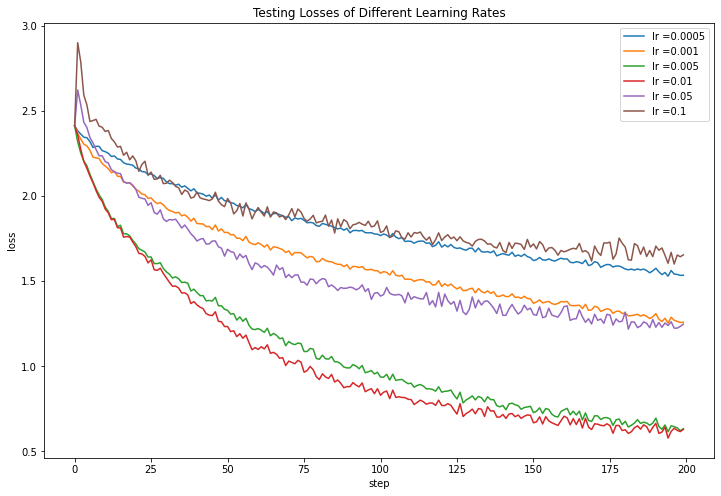

In [20]:
plt.figure(figsize=(12,8))
plt.title('Testing Losses of Different Learning Rates')
plt.ylabel('loss')
plt.xlabel('step')
for i in range(len(lrs)):
  print('Learning Rate:', lrs[i])
  print('Initial Loss Mean:', mlp_adam_losses_avgs[i][0])
  print('Final Loss Mean:', mlp_adam_losses_avgs[i][-1])
  print('-----------------------------')
  plt.plot(mlp_adam_losses_avgs[i],label= 'lr =' + str(lrs[i]))
plt.legend()

# MLP LSTM

In [21]:
def flatten_mlp_params(mlp_params):
  w1 = mlp_params['fc1']['w'].reshape(-1)
  b1 = mlp_params['fc1']['b']
  w2 = mlp_params['fc2']['w'].reshape(-1)
  b2 = mlp_params['fc2']['b']

  return jnp.concatenate((w1,b1,w2,b2))[:,None]

def reconstruct_mlp_params(grads_mlp):
  grads_mlp = jnp.squeeze(grads_mlp, 1)
  w1 = lax.dynamic_slice(grads_mlp, [0], [15680]).reshape((784,20))
  b1 = lax.dynamic_slice(grads_mlp, [15680], [20])
  w2 = lax.dynamic_slice(grads_mlp, [15700], [200]).reshape((20,10))
  b2 = lax.dynamic_slice(grads_mlp, [15900], [10])

  grads_dict = {}
  grads_dict['fc1'] = {}
  grads_dict['fc2'] = {}
  grads_dict['fc1']['w'] = w1
  grads_dict['fc1']['b'] = b1
  grads_dict['fc2']['w'] = w2
  grads_dict['fc2']['b'] = b2

  return hk.data_structures.to_immutable_dict(grads_dict)

In [22]:
@jit
def mlp_lstm_inner_f(carry, i):
  mnist_batch_inner = lax.dynamic_slice(carry[4], [i*batch_sz, 0], [batch_sz, carry[4].shape[1]])
  labels_batch_inner = lax.dynamic_slice(carry[5], [i*batch_sz], [batch_sz])
  _, mlp_opt_update, mlp_get_params = optimizers.sgd(-1.0)
  (loss_mlp, _), grads_mlp = vag_mlp_forward(mlp_get_params(carry[3]), mnist_batch_inner, labels_batch_inner)
  grads_mlp_flattened = flatten_mlp_params(grads_mlp)
  grads_mlp_flattened = preproc_log(grads_mlp_flattened)
  delta_mlp, carry[1], carry[2] = lstm_forward(carry[0], grads_mlp_flattened, carry[1], carry[2])
  delta_mlp = reconstruct_mlp_params(delta_mlp)
  carry[3] = mlp_opt_update(0, delta_mlp, carry[3])
  return carry, loss_mlp

@jit
def mlp_lstm_inner_scan(lstm_params, prev_state_1, prev_state_2, mlp_opt_state, mnist_batch_outer, labels_batch_outer):
  init = [lstm_params, prev_state_1, prev_state_2, mlp_opt_state, mnist_batch_outer, labels_batch_outer]
  idx = jnp.arange(0, INNER_STEPS)
  [_, prev_state_1, prev_state_2, mlp_opt_state, _, _], losses_mlp = lax.scan(mlp_lstm_inner_f, init, idx)
  loss_lstm = jnp.sum(jnp.array(losses_mlp)) / len(losses_mlp)
  return loss_lstm, [prev_state_1, prev_state_2, mlp_opt_state]

g_mlp_lstm_inner_scan = grad(mlp_lstm_inner_scan, has_aux=True)

@jit
def mlp_lstm_step(step, lstm_params, prev_state_1, prev_state_2, mlp_opt_state, mnist_batch, labels_batch):
  _, mlp_opt_update, mlp_get_params = optimizers.sgd(-1.0)
  (loss_mlp, _), grads_mlp = vag_mlp_forward(mlp_get_params(mlp_opt_state), mnist_batch, labels_batch)
  grads_mlp_flattened = flatten_mlp_params(grads_mlp)
  grads_mlp_flattened = preproc_log(grads_mlp_flattened)
  delta_mlp, prev_state_1, prev_state_2 = lstm_forward(lstm_params, grads_mlp_flattened, prev_state_1, prev_state_2)
  delta_mlp = reconstruct_mlp_params(delta_mlp)
  mlp_opt_state = mlp_opt_update(0, delta_mlp, mlp_opt_state)
  return mlp_opt_state, prev_state_1, prev_state_2, loss_mlp
@jit
def mlp_lstm_f(carry, i):
  mnist_batch = lax.dynamic_slice(carry[4], [i*batch_sz, 0], [batch_sz, carry[4].shape[1]])
  labels_batch = lax.dynamic_slice(carry[5], [i*batch_sz], [batch_sz])
  mlp_opt_state, carry[1], carry[2], loss_mlp = mlp_lstm_step(i, carry[0], carry[1], carry[2], carry[3], mnist_batch, labels_batch)
  carry = [carry[0],carry[1], carry[2], mlp_opt_state, carry[4], carry[5]]
  return carry, loss_mlp

@jit
def mlp_lstm_update_scan(lstm_params, prev_state_1, prev_state_2, mlp_opt_state, mnist_, labels_):
  idx = jnp.arange(0, TEST_STEPS)
  init = [lstm_params, prev_state_1, prev_state_2, mlp_opt_state, mnist_, labels_]
  [_, _, _, mlp_opt_state, _, _], losses_mlp = lax.scan(mlp_lstm_f, init, idx)
  return mlp_opt_state, losses_mlp

In [23]:
def eval_mlp_lstm_optimizer(lstm_params, mode):
  if mode == 'val':
    eval_mlp_params = val_mlp_params
    eval_orders = val_orders
    eval_mnist = val_mnist
    eval_labels = val_labels
    eval_sz = val_sz
  else:
    eval_mlp_params = test_mlp_params
    eval_orders = test_orders
    eval_mnist = test_mnist
    eval_labels = test_labels
    eval_sz = test_sz

  mlp_lstm_losses_avg = None

  for i in range(eval_sz):
    mlp_params = eval_mlp_params[i]
    orders = eval_orders[i]
    
    eval_mnist_ = eval_mnist[order,:]
    eval_labels_ = eval_labels[order]

    prev_state_1 = hk.LSTMState(hidden = jnp.zeros((15910, hidden_sz)), cell = jnp.zeros((15910, hidden_sz)))
    prev_state_2 = hk.LSTMState(hidden = jnp.zeros((15910, hidden_sz)), cell = jnp.zeros((15910, hidden_sz)))

    mlp_opt_init, mlp_opt_update, mlp_get_params = optimizers.sgd(-1.0)
    mlp_opt_state = mlp_opt_init(mlp_params)
    
    mlp_opt_state, losses_mlp = mlp_lstm_update_scan(lstm_params, prev_state_1, prev_state_2, mlp_opt_state, eval_mnist_, eval_labels_)
    
    if mlp_lstm_losses_avg is None:
      mlp_lstm_losses_avg = jnp.array(losses_mlp)
    else:
      mlp_lstm_losses_avg += jnp.array(losses_mlp)

  mlp_lstm_losses_avg /= eval_sz

  return mlp_lstm_losses_avg

def train_mlp_lstm_optimizer(lstm_params, opt_state, train_sz, lr):
  best_mean_loss = 999999
  best_last_loss = 999999
  half_lr = 5
  early_stop = 20
  since_last_best = 0
  lstm_params_ckpts_1 = []
  lstm_params_ckpts_2 = []
  for train_idx in range(train_sz):
    _, opt_update, _ = optimizers.adam(lr)
    mlp_params = train_mlp_params[i]
    orders = train_orders[i]
    
    train_mnist_ = train_mnist[order,:]
    train_labels_ = train_labels[order]

    prev_state_1 = hk.LSTMState(hidden = jnp.zeros((15910, hidden_sz)), cell = jnp.zeros((15910, hidden_sz)))
    prev_state_2 = hk.LSTMState(hidden = jnp.zeros((15910, hidden_sz)), cell = jnp.zeros((15910, hidden_sz)))

    mlp_opt_init, mlp_opt_update, mlp_get_params = optimizers.sgd(-1.0)
    mlp_opt_state = mlp_opt_init(mlp_params)

    for outer_step in range(outer_steps):
      mnist_batch_outer = train_mnist_[outer_step*inner_steps*batch_sz:(outer_step+1)*inner_steps*batch_sz,:]
      labels_batch_outer = train_labels_[outer_step*inner_steps*batch_sz:(outer_step+1)*inner_steps*batch_sz]

      grads_lstm, [prev_state_1, prev_state_2, mlp_opt_state] = g_mlp_lstm_inner_scan(lstm_params, prev_state_1, prev_state_2, mlp_opt_state, mnist_batch_outer, labels_batch_outer)
      opt_state = opt_update(outer_step + outer_steps * train_idx, grads_lstm, opt_state)
      lstm_params = get_params(opt_state)

    val_losses_avg = eval_mlp_lstm_optimizer(lstm_params, 'val')

    if jnp.mean(val_losses_avg) < best_mean_loss or val_losses_avg[-1] < best_last_loss:
      if jnp.mean(val_losses_avg) < best_mean_loss:
        best_mean_loss = jnp.mean(val_losses_avg)
        lstm_params_ckpts_1.append(lstm_params)
      if val_losses_avg[-1] < best_last_loss:
        best_last_loss = val_losses_avg[-1]
        lstm_params_ckpts_2.append(lstm_params)
      since_last_best = 0
    
    else:
      since_last_best += 1
      if ((since_last_best + 1) % half_lr) == 0:
        lr = lr / 2
        print('lr halved at epoch', train_idx)
      if since_last_best == early_stop:
        print('stopped at epoch', train_idx)
        break

  return lstm_params_ckpts_1, lstm_params_ckpts_2

In [32]:
lr = 0.001
x_init = jnp.ones((15910, 1))
prev_state_init = hk.LSTMState(hidden = jnp.zeros((15910, hidden_sz)), cell = jnp.zeros((15910, hidden_sz)))
key, subkey = random.split(key)
lstm_params = lstm.init(subkey, x_init, prev_state_init, prev_state_init)
lstm_params = init_lstm_params(lstm_params)

In [33]:
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(lstm_params)

In [34]:
lstm_params_ckpts_1, lstm_params_ckpts_2 = train_mlp_lstm_optimizer(lstm_params, opt_state, train_sz, lr)

lr halved at epoch 7
lr halved at epoch 17
lr halved at epoch 24
lr halved at epoch 29
lr halved at epoch 34
lr halved at epoch 40
lr halved at epoch 63
lr halved at epoch 69
lr halved at epoch 74
lr halved at epoch 79
lr halved at epoch 84
stopped at epoch 85


In [37]:
adam_lstm_losses_avg = eval_mlp_lstm_optimizer(lstm_params_ckpts_2[-1], 'test')

Learning Rate: 0.0005
Initial Loss Mean: 2.4116735
Final Loss Mean: 1.534278
-----------------------------
Learning Rate: 0.001
Initial Loss Mean: 2.4116735
Final Loss Mean: 1.2578607
-----------------------------
Learning Rate: 0.005
Initial Loss Mean: 2.4116735
Final Loss Mean: 0.63318247
-----------------------------
Learning Rate: 0.01
Initial Loss Mean: 2.4116735
Final Loss Mean: 0.6298414
-----------------------------
Learning Rate: 0.05
Initial Loss Mean: 2.4116735
Final Loss Mean: 1.2468245
-----------------------------
Learning Rate: 0.1
Initial Loss Mean: 2.4116735
Final Loss Mean: 1.6540372
-----------------------------
LSTM
Initial Loss Mean: 2.3869116
Final Loss Mean: 1.0334933
-----------------------------


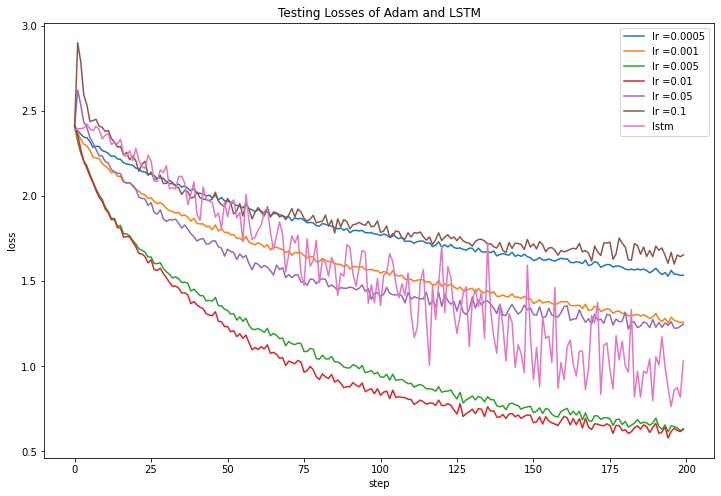

In [39]:
plt.figure(figsize=(12,8))
plt.title('Testing Losses of Adam and LSTM')
plt.ylabel('loss')
plt.xlabel('step')
for i in range(len(lrs)):
  print('Learning Rate:', lrs[i])
  print('Initial Loss Mean:', mlp_adam_losses_avgs[i][0])
  print('Final Loss Mean:', mlp_adam_losses_avgs[i][-1])
  print('-----------------------------')
  plt.plot(mlp_adam_losses_avgs[i],label= 'lr =' + str(lrs[i]))

print('LSTM')
print('Initial Loss Mean:', adam_lstm_losses_avg[0])
print('Final Loss Mean:', adam_lstm_losses_avg[-1])
print('-----------------------------')
plt.plot(adam_lstm_losses_avg,label= 'lstm')
plt.legend()